# Python notebook to reproduce _Supplementary Figure 2_

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import torch
import anndata
import numpy as np
import json

sys.path.append(os.path.join(sys.path[0], '../'))
import plot_settings
import plot_utils
from figures.additional_utils import aging_utils, velocity_plot_utils

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
fig_dir = 'supplementary/figure_2/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

In [4]:
data, organs, gen_ts = aging_utils.load_imputed_early_development_data('Mouse', -5, 13)
N, T, M = data['Brain'].shape
organ_listing = [org for org in organs for _ in range(N) for _ in range(T)]
time_listing = []
for org in organs:
    ts = []
    for n in range(N):
        ts.append(np.arange(-5, 13, 0.1))
    time_listing.append(np.stack(ts, axis=0))
time_listing = np.stack(time_listing, axis=0)
time_listing = time_listing.reshape(-1)

In [6]:
from sklearn.decomposition import PCA

full_data = np.stack([data[org] for org in data], axis=0)  # O x N x T x M
flattened_data = full_data.reshape(-1, M)

pca_data = PCA(n_components=2, random_state=15).fit_transform(flattened_data)
shaped_pca_data = pca_data.reshape(-1, N, T, 2)

shaped_pca_velocity = []
for org in range(len(organs)):
    vels = []
    for n in range(N):
        vels.append(np.stack(
            [shaped_pca_data[org][n][t+1] - shaped_pca_data[org][n][t-1] if t != T-1 else np.zeros((2))
             for t in range(T)], axis=0))
    shaped_pca_velocity.append(np.stack(vels, axis=0))
    
shaped_pca_velocity = np.stack(shaped_pca_velocity, axis=0)
pca_velocity = shaped_pca_velocity.reshape(-1, 2)

def moving_average_results(vel, minT, maxT, granularity, k=None, restrict_to_indices=False):    
    N, Tfull, _ = vel.shape
    smoothed_vel = []
    if k is None:
        k = int(1. / granularity)
    imputed_ts = np.arange(minT, maxT, granularity)
    for t in range(Tfull):
        mint = max(0, t-k)
        maxt = min(Tfull, t+k)
        
        if not restrict_to_indices or abs(imputed_ts[t] - np.round(imputed_ts[t])) < 1e-2:
            avg = np.mean(vel[:, mint:maxt, :], axis=1)  # N x M
            if not restrict_to_indices:
                smoothed_vel.append(avg)
            else:
                cnt = int(1. / granularity)
                smoothed_vel.extend([avg for _ in range(cnt)])
    return np.stack(smoothed_vel, axis=1)  # N x Tfull x M

avg_pca_velocities = np.mean(shaped_pca_velocity, axis=1)
smoothed_avg_vels = moving_average_results(avg_pca_velocities, -5, 13, 0.1, 1, True)
avg_pca_velocities = np.stack([avg_pca_velocities for _ in range(N)], axis=1)
smoothed_avg_velocities = np.stack([smoothed_avg_vels for _ in range(N)], axis=1)
flat_avg_pca_velocities = avg_pca_velocities.reshape(-1, 2)
flat_smoothed_avg_vels = smoothed_avg_velocities.reshape(-1, 2)

# Code to reproduce Supplementary Figure 2

Supplementary Fig. 2a

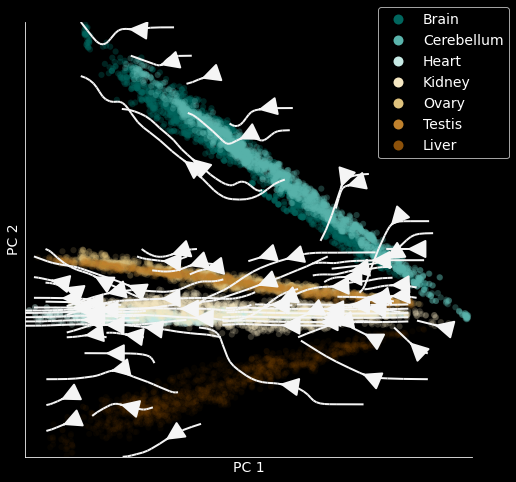

In [9]:
%matplotlib inline

from importlib import reload
reload(plot_settings)

ax = plot_settings.get_double_square_axis()
xid = 7
colors = plot_settings.get_organ_color_palette()
organ_ordering = ['Brain', 'Cerebellum', 'Heart', 'Kidney', 'Ovary', 'Testis', 'Liver']
for i, org in enumerate(organ_ordering[:xid]):
    idxs = np.where(np.asarray(organ_listing) == org)
    org_adata = anndata.AnnData(flattened_data[idxs])
    org_adata.obs['organ'] = np.asarray(organ_listing)[idxs]
    org_adata.obs['time'] = time_listing.astype(np.float64)[idxs]
    org_adata.obsm['X_tsne'] = pca_data[idxs]

    velocity_plot_utils.velocity_embedding_stream(
        org_adata, V=flat_smoothed_avg_vels[idxs], n_neighbors=100, cutoff_perc=5, 
        alpha=0.1 * (7-i)/2., density=0.1, smooth=1.0, size=150, linewidth=2, 
        color=colors[i], arrowsize=4, ax=ax, arrow_color='whitesmoke', 
        legend_loc='upper right')
    
lp = lambda i: plt.plot([],color=colors[i], ms=10, 
                        mec="none", label=organ_ordering[i], ls="", 
                        marker="o")[0]
handles = [lp(i) for i in range(len(organs[:xid]))]

ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plot_utils.format_legend(ax, handles, organ_ordering[:xid])
plot_utils.put_legend_outside_plot(ax)
plot_utils.format_ax(ax)
plt.savefig(fig_dir + 'figure_2a.pdf')

Supplementary Fig. 2b

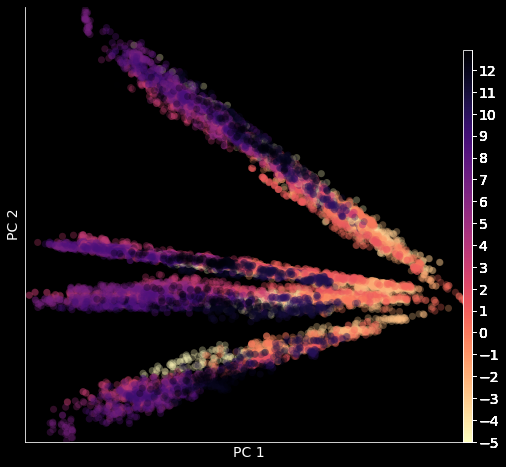

In [10]:
ax = plot_settings.get_double_square_axis()

colorbar_ticks = []

for i, org in enumerate(organs):
    idxs = np.where(np.asarray(organ_listing) == org)
    org_adata = anndata.AnnData(flattened_data[idxs])
    org_adata.obs['organ'] = np.asarray(organ_listing)[idxs]
    org_adata.obs['time'] = time_listing.astype(np.float64)[idxs]
    org_adata.obsm['X_tsne'] = pca_data[idxs]

    velocity_plot_utils.velocity_embedding_stream(
        org_adata, V=flat_smoothed_avg_vels[idxs], 
        n_neighbors=100, cutoff_perc=1, color='time', 
        alpha=0.3, density=0.1, smooth=1.0,
        size=200, linewidth=0, arrowsize=0, ax=ax,
        arrow_color='whitesmoke', 
        color_map='magma_r', legend_loc='upper right')
    
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
plot_utils.format_ax(ax)
plt.savefig(fig_dir + 'figure_2b.pdf')